In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from util.preprocess import *

# Preprocess data
See paper for more details. 

## Load in data

In [2]:
# data for dir
data_dir = "../data/unprocessed-iphone12prowide.npz"
data = np.load(data_dir)

# Read in data elements
patterns = data['patterns']
lens_positions = data['lens_positions']
api_positions = data['api_positions']
infocus_index = data['infocus_index']
blurry_dots = data['dots']
blurry_dots_conjugate = data['dots_conjugate']
blurry_black = data['black_capture']
blurry_white = data['white_capture']

In [3]:
# some parameters
height, width = blurry_dots.shape[-2], blurry_dots.shape[-1]


Text(0.5, 0.98, 'Calibration and radiometry patterns')

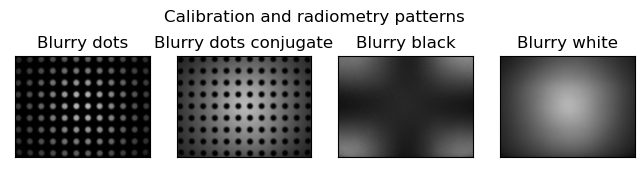

In [4]:
# Let's plot our input data at a lens position
captures = [blurry_dots, blurry_dots_conjugate, blurry_black, blurry_white]
labels = ["Blurry dots", "Blurry dots conjugate", "Blurry black", "Blurry white"]
fig, ax = plt.subplots(1, 4, figsize=[8,2])
for i, capture in enumerate(captures):
    ax[i].imshow(capture[0,...], cmap='gray')
    ax[i].set_xticks([])    
    ax[i].set_yticks([])
    ax[i].set_title(labels[i])
fig.suptitle("Calibration and radiometry patterns")

In [5]:
# Set up the dot grid params
dot_grid = (9,12) # number of dots (rows, cols)
neighbourhood_size = 140
dot = dot_grid[0]

# Load in the sharp polka dot pattern
sharp_polka = data['dot_pattern']
obj_points_h = data['centres_h']
obj_points_w = data['centres_w']
obj_points = np.stack((obj_points_w, obj_points_h, np.zeros(dot_grid[0]*dot_grid[1])), axis=-1).astype(np.float32)

Text(0.5, 1.0, 'Sharp calibration pattern with centres')

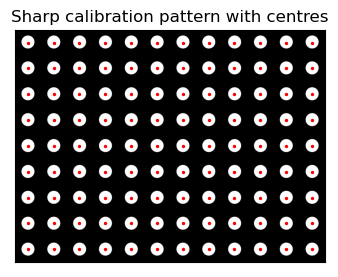

In [6]:
# Plot our shapr calibration pattern
fig, ax = plt.subplots(1, 1, figsize=[4,4])
ax.imshow(sharp_polka, cmap='gray')
ax.scatter(obj_points_w, obj_points_h, c='r', s=2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Sharp calibration pattern with centres")

## Absolute homography estimation

1. Find (most) in focus image in stack
2. Estimate camera parameters K, radial distortion coefficients D for the most in focus image
3. Map most in focus image to linear perspective with K, D
4. Solve for a homography H that maps linear perspective in focus image to sharp ground truth

In [7]:
# If the calibration pattern does not fill the entire FoV,
# do some manual cropping at the edges to clean things up 
# in this example, the calibration pattern fills the entire FoV
# so we just put in some small filler values
top = 1
bottom = 1
left = 1
right = 1

In [8]:
# Preprocess in focus captured image of calibration pattern 
# for distortion estimations

# Let's binarize the polka dot pattern for a better radial distortion correction
binarize_infocus = binarize(
    blurry_dots[infocus_index, ...], 
    blurry_dots_conjugate[infocus_index, ...]
)
# May have to do some manual cropping at the edges to clean things up...
binarize_infocus[:top, :] = 0
binarize_infocus[-bottom:, :] = 0
binarize_infocus[:, :left] = 0
binarize_infocus[:, -right:] = 0

# Make uint8 for opencv
binarize_infocus = (255*binarize_infocus).astype(np.uint8)

# Detect circles in the binarized polka dot pattern
# Will need some manual adjustment of the values
refined_circles = detect_circle_centers_with_subpixel_accuracy(
    cv2.cvtColor(binarize_infocus, cv2.COLOR_GRAY2BGR), 
    dp=1, minDist=300, param1=100, param2=24, 
    minRadius=80, maxRadius=100, 
    neighborhood_size=neighbourhood_size, neighborhood=True
)

# SUPER IMPORTANT: Sort the detected circles
# If skipped, then the detected circles will not be in the correct order
# and homographies will be messed up
img_points = sort_circles(refined_circles, *dot_grid)
print(refined_circles.shape, img_points.shape, obj_points.shape)


detected circles (1, 108, 3)
(108, 3) (108, 2) (108, 3)


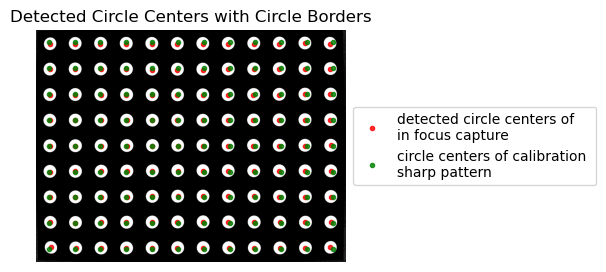

In [9]:
# Let's take a look at the detected circle centers vs the true circle centers
# Our goal is to find distortion parameters to correct these discrepancies
plt.figure(figsize=(4,4))
plt.imshow(binarize_infocus, cmap='gray')
plt.plot(img_points[:,0], img_points[:,1], 'r.', alpha=0.8, label="detected circle centers of \nin focus capture")
plt.plot(obj_points[:,0], obj_points[:,1], 'g.', alpha=0.8, label="circle centers of calibration \nsharp pattern")
plt.title('Detected Circle Centers with Circle Borders')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('off')
plt.show()

In [10]:
# Get radial distortion coefficients
ret, camera_matrix, dist_coeffs, rvecs, tvecs = calibrate_camera([obj_points], [img_points], binarize_infocus.shape[1], binarize_infocus.shape[0])
radial_coeffs = [dist_coeffs[0,0], dist_coeffs[1,0], dist_coeffs[4,0]]

print(f"Radial distortion coefficients: \n", radial_coeffs)
print("Camera Matrix: \n", np.array2string(camera_matrix, formatter={'float_kind':lambda x: f"{x:.3f}"}))
print("Rotation Vectors: \n", rvecs[0])
print("Translation Vectors: \n", tvecs[0])

Radial distortion coefficients: 
 [46.07128132483435, -47870.06078913248, -62.710432570446734]
Camera Matrix: 
 [[79794.253 0.000 2091.801]
 [0.000 79757.254 1376.334]
 [0.000 0.000 1.000]]
Rotation Vectors: 
 [[ 0.02236198]
 [ 0.03237796]
 [-0.00192682]]
Translation Vectors: 
 [[-2105.68822939]
 [-1372.38827427]
 [81632.03998412]]


In [11]:
# Undistort the polka dot pattern
linearized_infocus_image = undistort_radial(binarize_infocus, camera_matrix, dist_coeffs)

Text(0.5, 1.0, 'Difference between undistorted and distorted image')

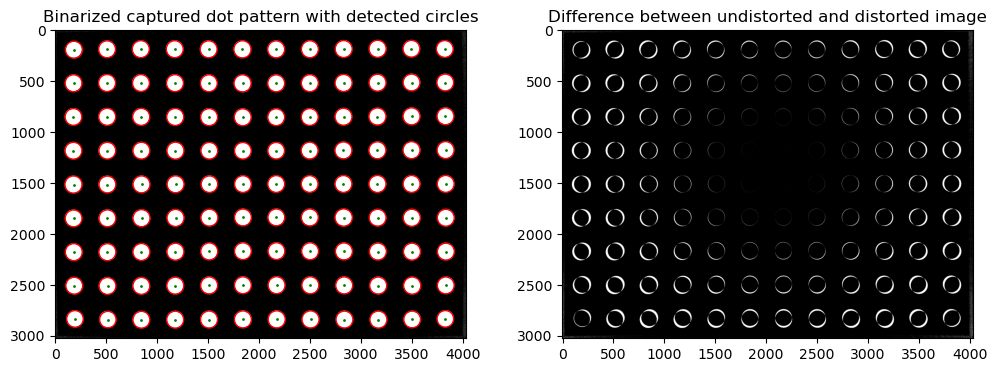

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].imshow(binarize_infocus, cmap='gray')
ax[0].plot(img_points[:,0], img_points[:,1], 'go', markersize=1)
for circle_center in refined_circles:
    circle = plt.Circle((circle_center[0], circle_center[1]), circle_center[2], color='r', fill=False)
    ax[0].add_patch(circle)
ax[0].set_title('Binarized captured dot pattern with detected circles')
ax[1].imshow(np.abs(np.float32(linearized_infocus_image) - np.float32(binarize_infocus)), cmap='gray')
ax[1].set_title('Difference between undistorted and distorted image')

In [13]:
# Solve for a homography that maps the linearized in focus image to the polka dot pattern

# first, need to detect centres again
# Detect circles in the binarized polka dot pattern
refined_circles = detect_circle_centers_with_subpixel_accuracy(
    cv2.cvtColor(linearized_infocus_image, cv2.COLOR_GRAY2BGR), 
    dp=1, minDist=300, param1=100, param2=24,
    minRadius=80, maxRadius=100, 
    neighborhood_size=neighbourhood_size, neighborhood=True
    )

# Sort the detected circles
img_points = sort_circles(refined_circles, dot_grid[0], dot_grid[1])

# Get homography
sharp_coords_linearized_infocus, H, invH, _, _ = apply_homography(obj_points, img_points, sharp_polka, thresh=10.0)
reprojection_err, std_err, transformed_coords = reprojection_error(obj_points[:,:2], img_points, invH)

detected circles (1, 108, 3)
src:  (108, 2) qry:  (108, 2)


Text(0.5, 1.0, 'linearized in focus capture \nreproj err = 0.908+/-0.600')

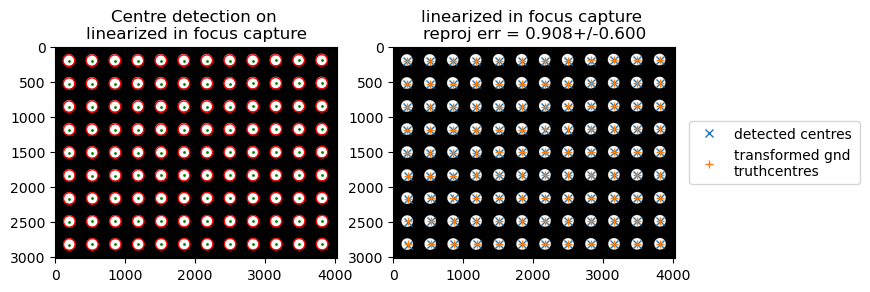

In [14]:
# plot the transformed_coords on top of obj_points
fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].imshow(sharp_coords_linearized_infocus, cmap='gray')
ax[0].plot(img_points[:,0], img_points[:,1], 'go', markersize=1)
for circle_center in refined_circles:
    circle = plt.Circle((circle_center[0], circle_center[1]), circle_center[2], color='r', fill=False)
    ax[0].add_patch(circle)
ax[0].set_title('Centre detection on \nlinearized in focus capture')
ax[1].imshow(sharp_coords_linearized_infocus, cmap='gray')
ax[1].plot(img_points[:,0], img_points[:,1], 'x', markersize=6, label='detected centres')
ax[1].plot(transformed_coords[:,0], transformed_coords[:,1], '+', markersize=6, label='transformed gnd \ntruthcentres')
ax[1].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)
ax[1].set_title('linearized in focus capture \nreproj err = {:.3f}+/-{:.3f}'.format(reprojection_err, std_err))

In [15]:
# Let's do the opposite now
# Map the polka dot pattern to the linearized in focus image
# use H
# Warp the image
gnd_infocus_linear_perspective = cv2.warpPerspective(
    sharp_polka,invH,(width, height),
    flags=(cv2.INTER_LINEAR), 
    borderMode=cv2.BORDER_CONSTANT, 
    borderValue = [0,0,0,0])

Text(0.5, 1.0, 'GND pattern mapped to linearized in focus image')

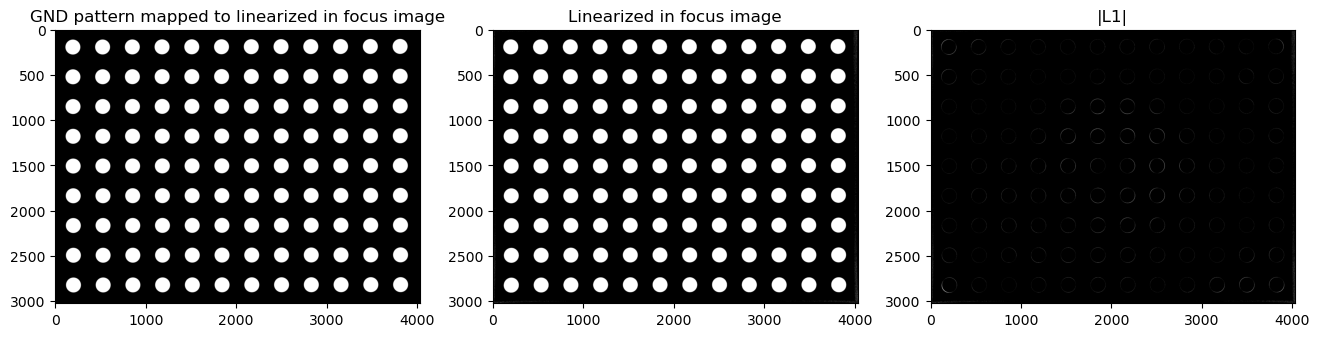

In [16]:
# Plot the difference between the gnd_infocus_linear_persoective and the linearized_infocus_image, and the two original images
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[2].imshow(norm_img(np.abs(norm_img(gnd_infocus_linear_perspective) - norm_img(linearized_infocus_image))), cmap='gray')
ax[2].set_title('|L1|')
ax[1].imshow(linearized_infocus_image, cmap='gray')
ax[1].set_title('Linearized in focus image')
ax[0].imshow(gnd_infocus_linear_perspective, cmap='gray')
ax[0].set_title('GND pattern mapped to linearized in focus image')

## Relative Homography Estimation
1. Apply radial distortzion coefficients D to each image in the focal stack. Now, we have a linear perspective focal stack. 
2. Find an image scaling-only homography S_i that maps each linear perspective image in the focal stack to the in focus image. 

In [17]:
# Preprocess focal stack for linearization
linearized_focal_stack = np.zeros((2, len(lens_positions), height, width))
binarized_linearized_focal_stack = np.zeros((len(lens_positions), height, width), dtype=np.uint8)

for ind_p in range(len(lens_positions)):
    # Undistort the polka dot pattern
    linearized_focal_stack[0,ind_p,...] = undistort_radial(np.float32(blurry_dots[ind_p, ...]), camera_matrix, dist_coeffs) 
    linearized_focal_stack[1,ind_p,...] = undistort_radial(np.float32(blurry_dots_conjugate[ind_p, ...]), camera_matrix, dist_coeffs) 

    # Let's binarize the polka dot pattern for a better radial distortion correction
    binarized = binarize(
        linearized_focal_stack[0, ind_p, ...], 
        linearized_focal_stack[1, ind_p, ...]
    )
    # Unforuntately, may have to do some manual cropping at the edges to clean things up...
    binarized[:top, :] = 0
    binarized[-bottom:, :] = 0
    binarized[:, :left] = 0
    binarized[:, -right:] = 0

    # Make a uint8
    binarized = (255*binarized).astype(np.uint8)
    binarized_linearized_focal_stack[ind_p,...] = binarized


Text(0.5, 0.98, 'Difference between each image in the linearized focal stack and the linearized in focus image')

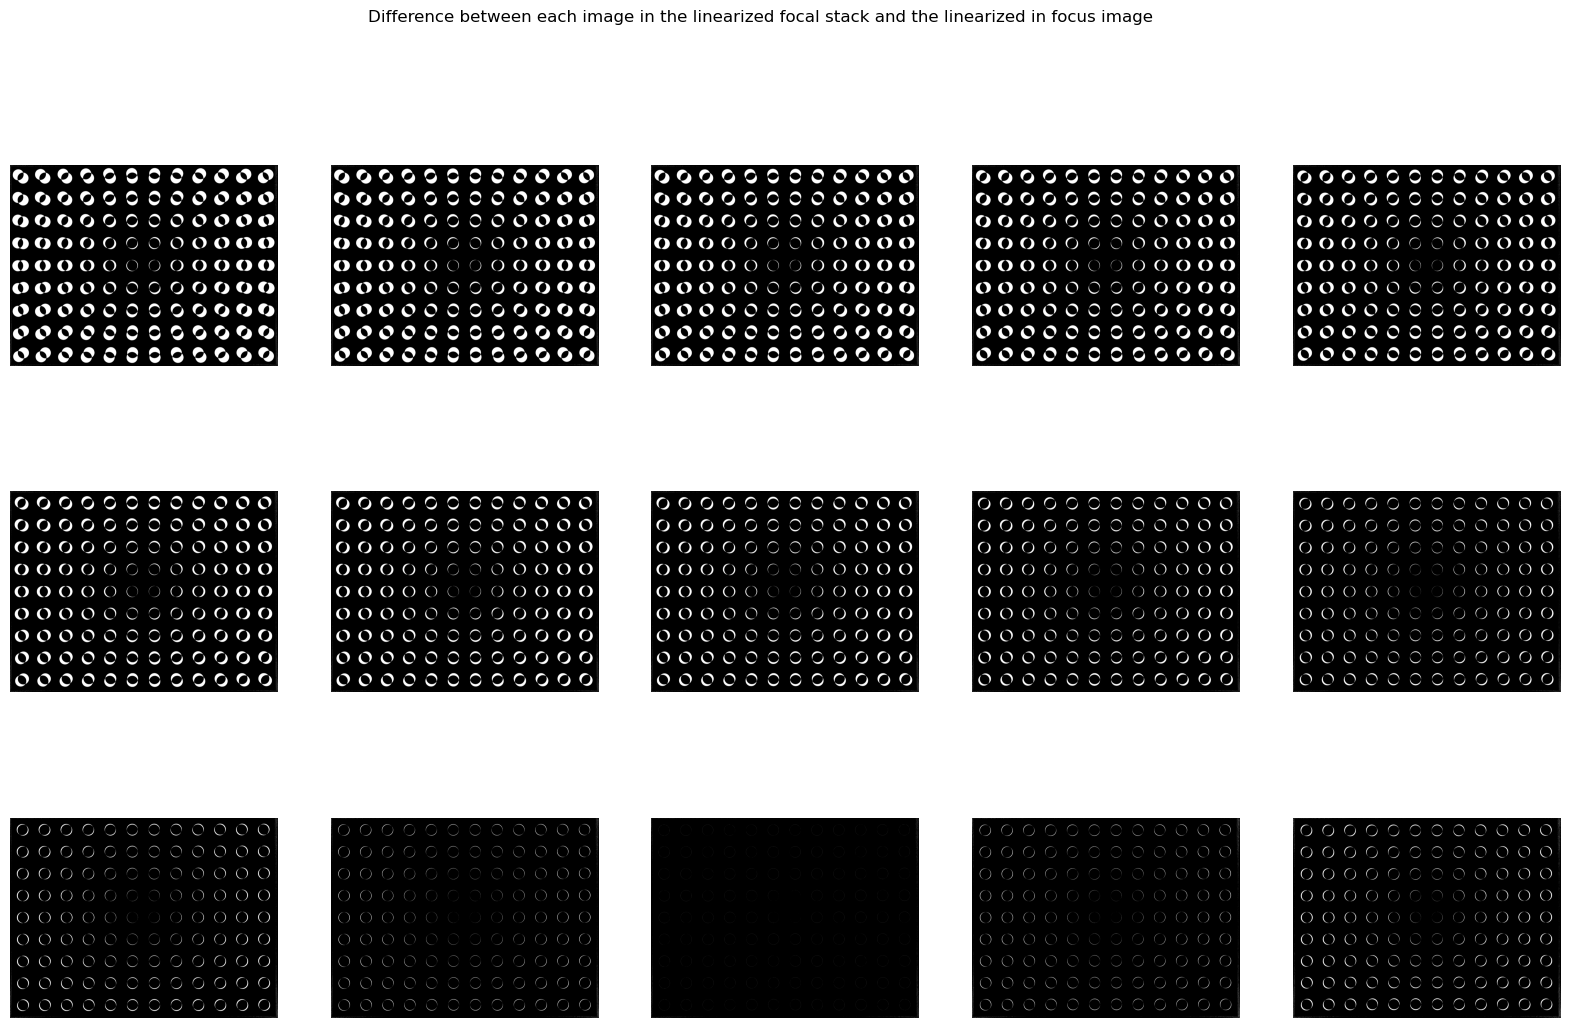

In [18]:
# Plot in two rows the difference between each image in the linearized focal stack and the linearized in focus image
# As we can see, the differences are greater when out of focus is more prominent
fig, ax = plt.subplots(3, 5, figsize=(20,12))
for ind_p in range(len(lens_positions)):
    ax[ind_p//5, ind_p%5].imshow(np.abs(
        norm_img(binarized_linearized_focal_stack[ind_p,...]) - norm_img(linearized_infocus_image)
        ), cmap='gray')
    ax[ind_p//5, ind_p%5].axis('off')
fig.suptitle("Difference between each image in the linearized focal stack and the linearized in focus image")

In [19]:
# Binarize each image in the linearized focal stack
img_points = np.zeros((len(lens_positions), (dot_grid[0])*dot_grid[1], 2))
refined_points = []
for ind_p in range(len(lens_positions)):
    # Detect circles in the binarized polka dot pattern
    refined_circles = detect_circle_centers_with_subpixel_accuracy(
        cv2.cvtColor(binarized_linearized_focal_stack[ind_p,...], cv2.COLOR_GRAY2BGR), 
        dp=1, minDist=280, param1=100, param2=12,
        minRadius=60, maxRadius=100, 
        neighborhood_size=neighbourhood_size, neighborhood=True
    )
    refined_points.append(refined_circles)
    # Sort the detected circles and do filtering
    all_circles = sort_circles(refined_circles, *dot_grid)
    img_points[ind_p,...] = sort_circles(all_circles, (dot_grid[0]), dot_grid[1])
refined_points = np.array(refined_points)


detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)
detected circles (1, 108, 3)


Text(0.5, 0.98, 'Detected Centres for each linearized image in focal stack')

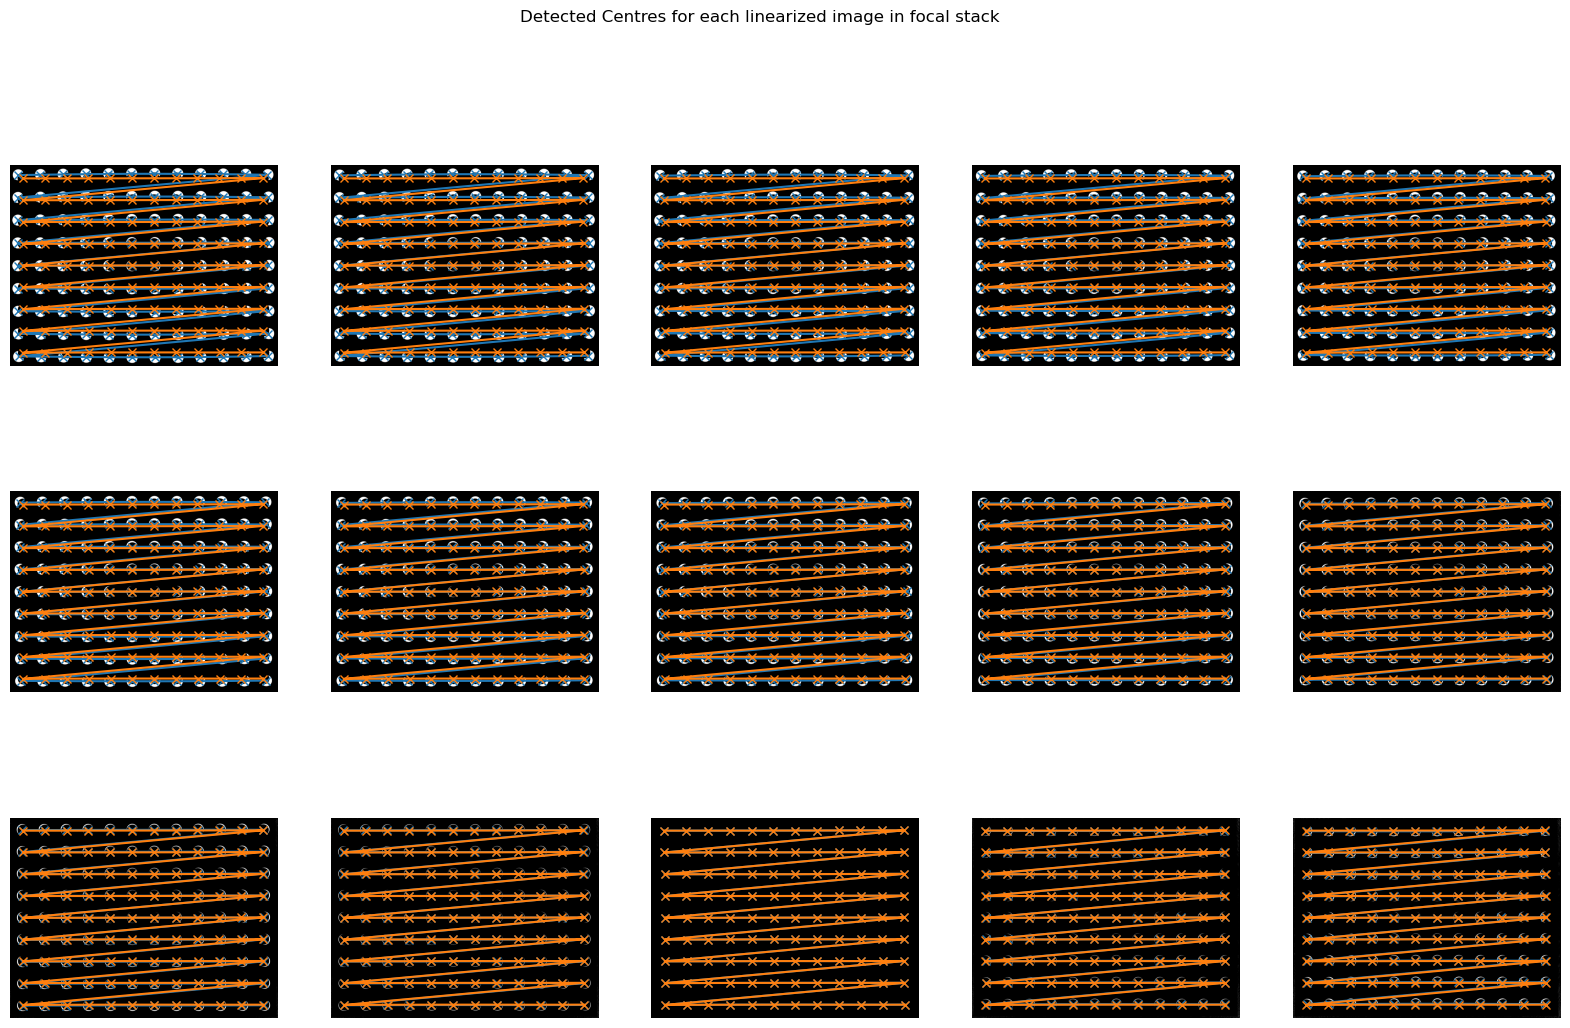

In [20]:
# Plot in two rows the difference between each image in the linearized focal stack 
# and the linearized in focus image to make sure centres are sorted
fig, ax = plt.subplots(3, 5, figsize=(20,12))
for ind_p in range(len(lens_positions)):
    ax[ind_p//5, ind_p%5].imshow(np.abs(binarized_linearized_focal_stack[ind_p,...]-binarized_linearized_focal_stack[infocus_index,...]), cmap='gray')
    ax[ind_p//5, ind_p%5].plot(img_points[ind_p,:,0], img_points[ind_p,:,1], 'x-', markersize=6, label='detected circles')
    ax[ind_p//5, ind_p%5].plot(img_points[infocus_index,:,0], img_points[infocus_index,:,1], 'x-', markersize=6, label='infocus circles')
    ax[ind_p//5, ind_p%5].axis('off')
fig.suptitle("Detected Centres for each linearized image in focal stack")

Text(0.5, 0.98, 'Detected Centres for each linearized image in focal stack')

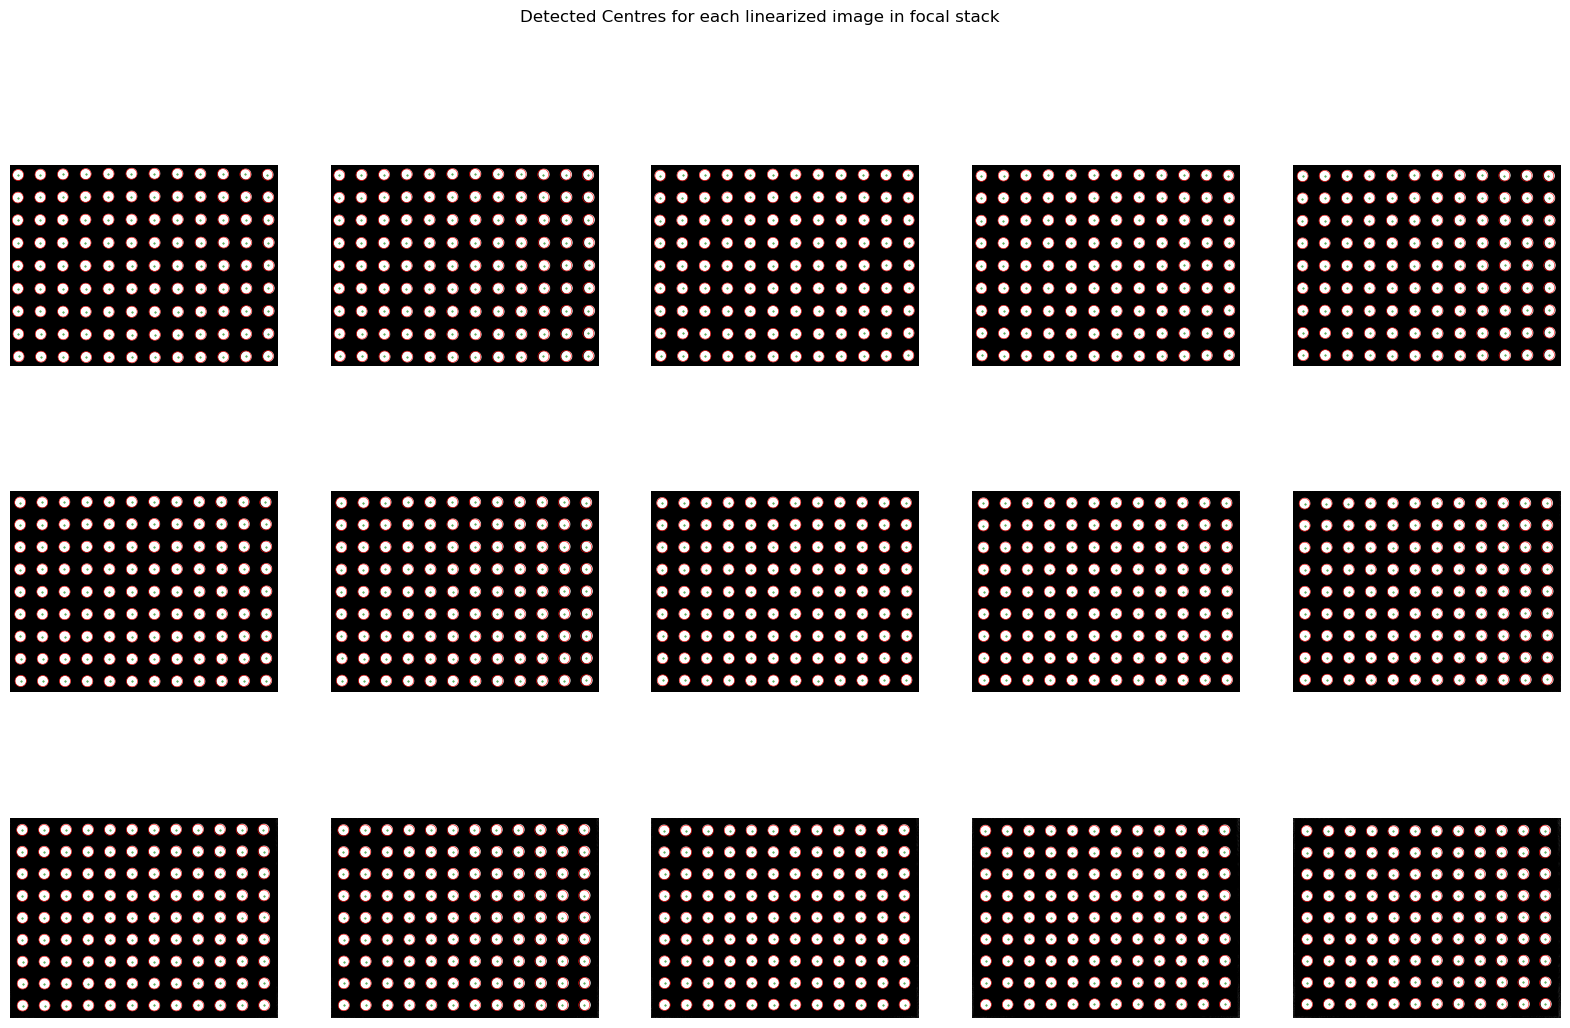

In [21]:
# Plot in two rows the difference between each image in the linearized focal stack and the linearized in focus image
fig, ax = plt.subplots(3, 5, figsize=(20,12))
for ind_p in range(len(lens_positions)):
    ax[ind_p//5, ind_p%5].imshow(binarized_linearized_focal_stack[ind_p,...], cmap='gray')
    ax[ind_p//5, ind_p%5].plot(refined_points[ind_p, :,0], refined_points[ind_p, :,1], 'go', markersize=0.4)
    ax[ind_p//5, ind_p%5].axis('off')

    for i in range(refined_points.shape[1]):
        circle_center = refined_points[ind_p,i,...]
        circle = plt.Circle((circle_center[0], circle_center[1]), circle_center[2], color='r', fill=False, linewidth=0.4)
        ax[ind_p//5, ind_p%5].add_patch(circle)

fig.suptitle("Detected Centres for each linearized image in focal stack")

In [22]:
# Let's try to map the sharp polka to the linearized in focus image,
# then use scale to map it to individual linearized images
# find the centre from the principal point
center_x, center_y = camera_matrix[0,2], camera_matrix[1,2] 

In [23]:
# Find scale factor between each image in the linearized focal stack and the linearized in focus image
scale_factor_avg = np.zeros((len(lens_positions)))
scale_factor_std = np.zeros((len(lens_positions)))
scaleH = np.zeros((len(lens_positions), 3, 3))
for ind_p in range(len(lens_positions)):
    temp_img_points = img_points[ind_p,...] - np.array([center_x, center_y])
    temp_infocus_points = img_points[infocus_index,...] - np.array([center_x, center_y])
    #temp = np.divide(img_points[i, ind_p,:,:2].reshape(1,-1), img_points[i, infocus_ps[i],:,:2].reshape(1,-1))
    temp = np.divide(temp_infocus_points.reshape(1,-1), temp_img_points.reshape(1,-1))
    scale_factor_avg[ind_p], scale_factor_std[ind_p] = temp.mean(), temp.std()
    scaling_matrix = np.array([
        [scale_factor_avg[ind_p], 0, 0],
        [0, scale_factor_avg[ind_p], 0],
        [0, 0, 1]
    ])

    # Translate the image to the center
    translation_matrix = np.array([
        [1, 0, -center_x * (scale_factor_avg[ind_p] - 1)],
        [0, 1, -center_y * (scale_factor_avg[ind_p] - 1)],
        [0, 0, 1]
    ])

    # Combine the scaling and translation matrices
    scaleH[ind_p] = np.dot(translation_matrix, scaling_matrix)

Text(0.5, 0, 'API position')

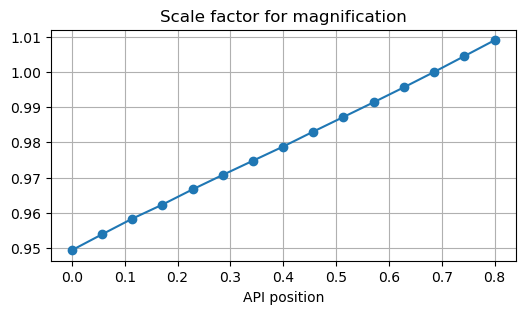

In [24]:
# Should see a linear relationship between diopeter space sampling (API position of iPhone) and scale factor
fig = plt.figure(figsize=(6,3))
plt.plot(api_positions, scale_factor_avg, '-o')
plt.grid('on')
plt.title("Scale factor for magnification")
plt.xlabel("API position")

In [25]:
# Scale the mapped sharp polka to the linearized in focus image to the linearized image
gnd_linear_perspective_stack = np.zeros((len(lens_positions), height, width))
for ind_p in range(len(lens_positions)):
    gnd_linear_perspective = cv2.warpPerspective(
        gnd_infocus_linear_perspective,np.linalg.inv(scaleH[ind_p]),(width, height),
        flags=(cv2.INTER_LINEAR), 
        borderMode=cv2.BORDER_CONSTANT, 
        borderValue = [0,0,0,0])

    gnd_linear_perspective_stack[ind_p, ...] = gnd_linear_perspective

Text(0.5, 1.0, 'GND pattern mapped to linearized in focus image')

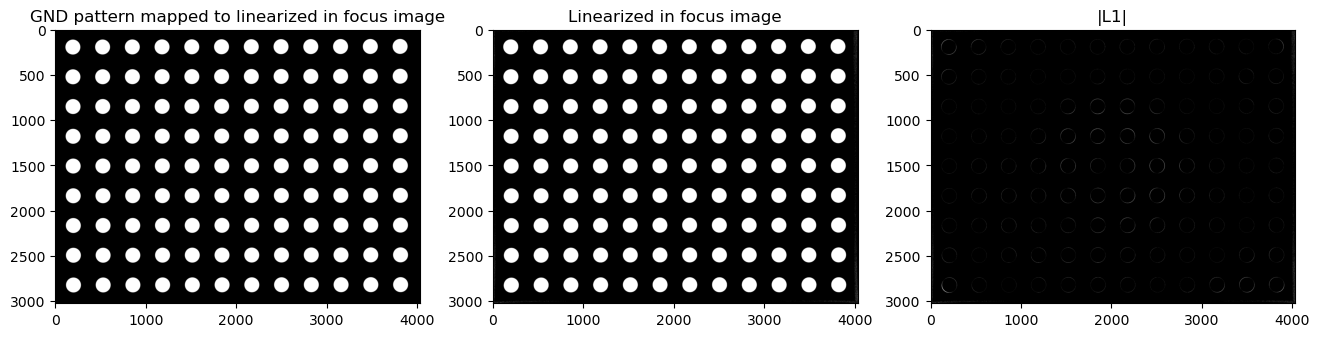

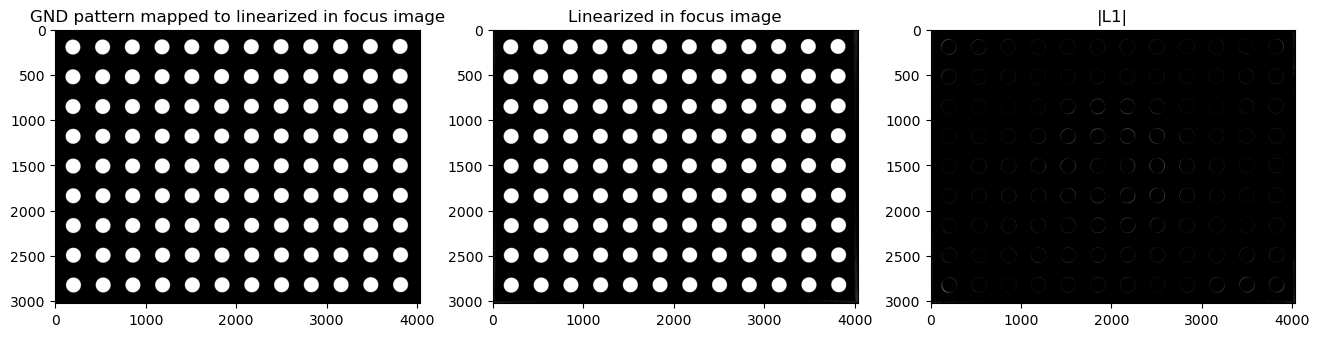

In [26]:
# Plot the difference between the gnd_infocus_linear_persoective and the linearized_infocus_image, and the two original images
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[2].imshow(np.abs(np.float32(gnd_infocus_linear_perspective) - norm_img(linearized_infocus_image)), cmap='gray')
ax[2].set_title('|L1|')
ax[1].imshow(linearized_infocus_image, cmap='gray')
ax[1].set_title('Linearized in focus image')
ax[0].imshow(gnd_infocus_linear_perspective, cmap='gray')
ax[0].set_title('GND pattern mapped to linearized in focus image')

# Plot the difference between the gnd_infocus_linear_persoective and the linearized_infocus_image, and the two original images
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[2].imshow(np.abs(norm_img(gnd_linear_perspective_stack[infocus_index,...]) - norm_img(binarized_linearized_focal_stack[infocus_index, ...])), cmap='gray')
ax[2].set_title('|L1|')
ax[1].imshow(linearized_infocus_image, cmap='gray')
ax[1].set_title('Linearized in focus image')
ax[0].imshow(gnd_infocus_linear_perspective, cmap='gray')
ax[0].set_title('GND pattern mapped to linearized in focus image')

## Mapping Sharp Ground Truth P to the RAW Capture Space of Each Image in Focal Stack -> for images (H,W)

1. Map P to in focus image’s linear perspective: P’ = HP
2. Create a sharp linear perspective focal stack: P_i’’ = S_i (HP)
3. Apply radial distortion K, D to P_i’’ to create sharp images in raw capture space
4. Apply radiometry correction with the white+black images taken in lens positions’ raw space

In [27]:
# For every images in the linearized gnd focal stack, add radial distortion to the image
# And then add radiometry correction with the white and blacks
radial_distorted_gnd_linear_perspective_stack = np.zeros((len(lens_positions), height, width))
for ind_p in range(len(lens_positions)):
    map_x, map_y = np.meshgrid(np.arange(width), np.arange(height))
    map_xy = np.stack((map_x, map_y), axis=-1).astype(np.float32)
    distorted_map_xy = distort_points(map_xy, camera_matrix, dist_coeffs)

    distorted_map_x = distorted_map_xy[..., 0].astype(np.float32)
    distorted_map_y = distorted_map_xy[..., 1].astype(np.float32)

    temp = cv2.remap(
        gnd_linear_perspective_stack[ind_p, ...], 
        distorted_map_x, 
        distorted_map_y, 
        cv2.INTER_LINEAR
    )
    # Add radiometry correction by multiplying by the whites
    radial_distorted_gnd_linear_perspective_stack[ind_p, ...] = np.multiply(temp, blurry_white[ind_p,...]) + \
        np.multiply(1-temp, blurry_black[ind_p,...])


Text(0.5, 0.98, '|L1| between the sharp [ radiometry( radial_distortion( magnification( homography(gnd pattern) ) ) )] and raw blurry dots  focal stack')

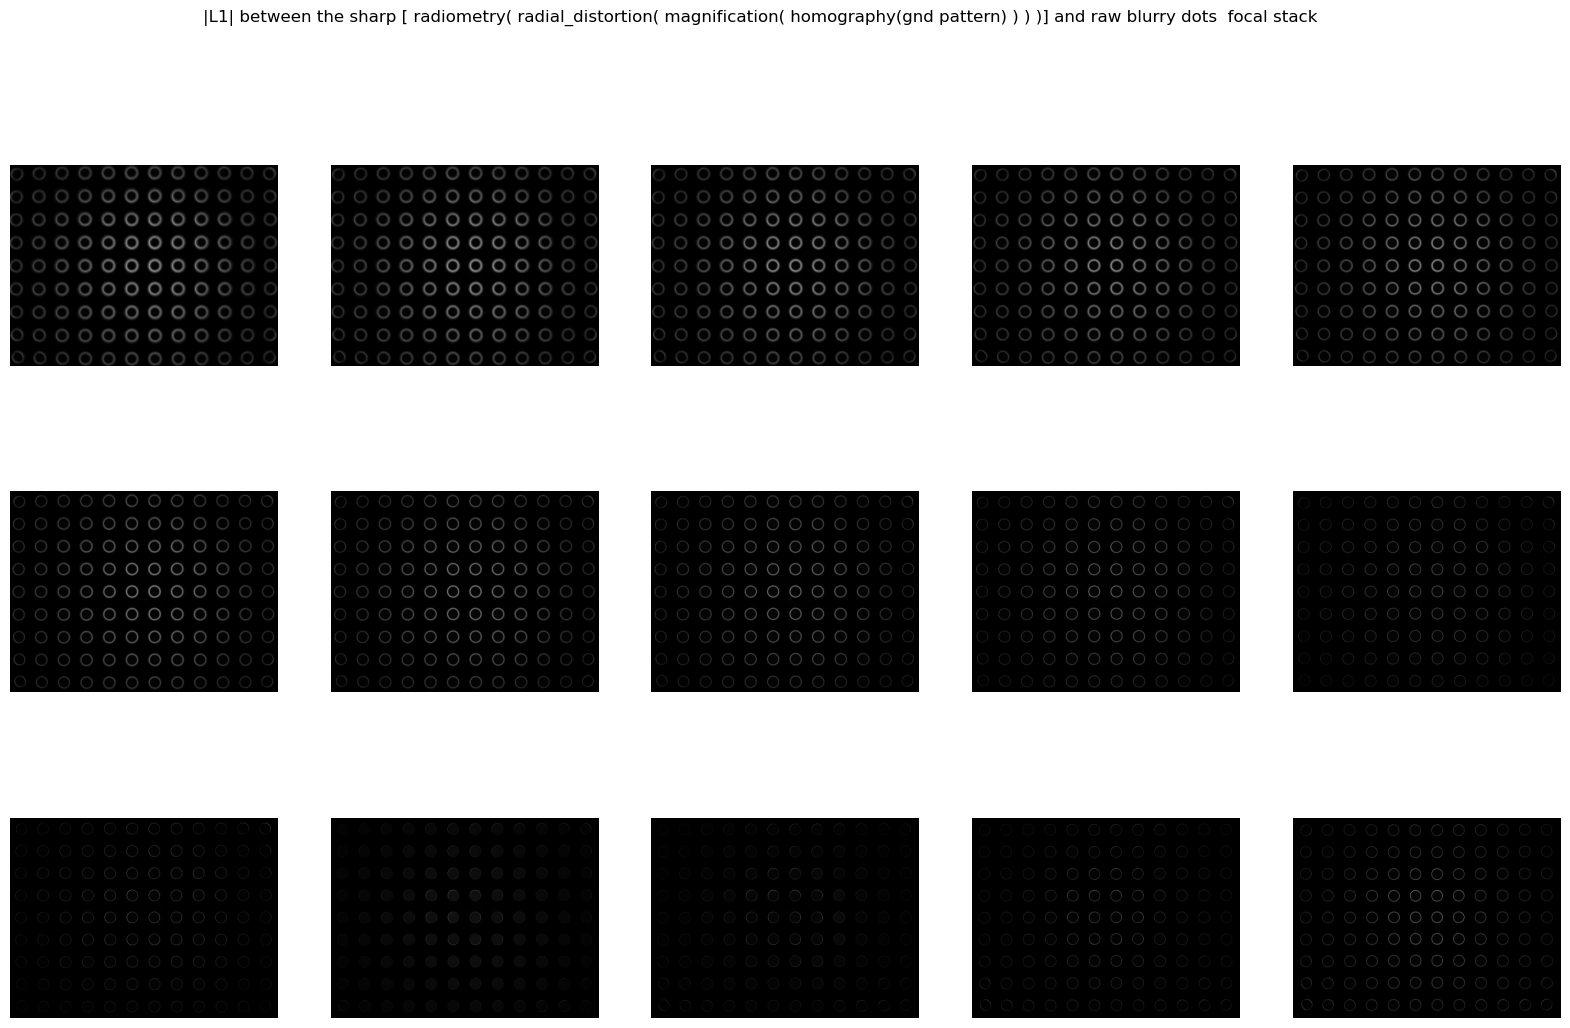

In [28]:
# Compare the gnd_linear_perspective_stack with the linearized_focal_stack
fig, ax = plt.subplots(3, 5, figsize=(20,12))
for ind_p in range(len(lens_positions)):
    ax[ind_p//5, ind_p%5].imshow(np.abs(
        norm_img(radial_distorted_gnd_linear_perspective_stack[ind_p, ...]) - norm_img(blurry_dots[ind_p,...])
        ), cmap='gray')
    ax[ind_p//5, ind_p%5].axis('off')
fig.suptitle('|L1| between the sharp [ radiometry( radial_distortion( magnification( homography(gnd pattern) ) ) )] and raw blurry dots  focal stack')

## Last step: Let's do this for the entire set of patterns captured
Map each pattern to linear perspective of in focus using all of the distortion and radiometry correction parameters found in previous steps. Use exact pipeline as how the dots pattern was corrected. Make sure the other patterns are captured under the exact same settings (positioning, monitor settings) as the radiometry and calibration patterns. 